In [1]:
import skrf as rf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def Antenna_setup(ANT_reflection_measure, frequency, Z_0=50, efficiency_coe=1):
    ANT_f = rf.Frequency.from_f(frequency, unit='Hz')
    ANT_S = np.zeros((len(frequency),2,2), dtype=complex)
    
    #Build S-matrix
    Chi = 1-np.abs(ANT_reflection_measure)**2
        
    ANT_S[:,0,0]=(1-np.conj(ANT_reflection_measure)-efficiency_coe*Chi)/(1-ANT_reflection_measure)
    ANT_S[:,0,1]=np.emath.sqrt(efficiency_coe*Chi)
    ANT_S[:,1,0]=np.emath.sqrt(efficiency_coe*Chi)
    ANT_S[:,1,1]=ANT_reflection_measure
    
    #Noise matrix
    T_0 = 290 #290K ref temp
    k_B = 1.380649e-23

    ANT_C = np.zeros((len(frequency),2,2))
    
    ANT_C[:,0,0]=T_0*k_B*(1-np.abs(ANT_S[:,0,0])**2-np.abs(ANT_S[:,0,1])**2)
    ANT_C[:,0,1]=-T_0*k_B*np.abs(ANT_S[:,1,0]*np.conj(ANT_S[:,0,0]) + ANT_S[:,1,1]*np.conj(ANT_S[:,0,1]))
    ANT_C[:,1,0]=-T_0*k_B*np.abs(ANT_S[:,0,0]*np.conj(ANT_S[:,1,0]) + ANT_S[:,0,1]*np.conj(ANT_S[:,1,1]))
    ANT_C[:,1,1]=T_0*k_B*(1-np.abs(ANT_S[:,1,1])**2-np.abs(ANT_S[:,1,0])**2)

    n_1 = ANT_C[:,0,0]*(np.abs(ANT_S[:,1,0])**2)-2*np.real(ANT_C[:,0,1]*ANT_S[:,1,0]*np.conj(ANT_S[:,0,0])) + ANT_C[:,1,1]*(np.abs(ANT_S[:,0,0])**2)
    n_2 = 0.5*(ANT_C[:,1,1]+n_1)/(ANT_C[:,1,1]*ANT_S[:,0,0]-ANT_C[:,0,1]*ANT_S[:,1,0])
    
    ANT_G_opt = n_2*(1-(np.emath.sqrt(1-1/np.abs(n_2)**2)))
    
    F_min = 1 + (ANT_C[:,1,1]-n_1*(np.abs(ANT_G_opt)**2))/(k_B*T_0*(np.abs(ANT_S[:,1,0])**2)*(1+np.abs(ANT_G_opt)**2))
    NF_min = 10*np.log10(F_min)

    Rn = (ANT_C[:,0,0] - 2*np.real(ANT_C[:,0,1]*np.conj((1+ANT_S[:,0,0])/ANT_S[:,1,0])) + ANT_C[:,1,1]*np.abs((1+ANT_S[:,0,0])/ANT_S[:,1,0])**2)/(4*T_0*k_B)

    ANT = rf.Network(f=frequency/1e9, s=ANT_S, z0=Z_0, noisy=True)
    ANT.set_noise_a(noise_freq=ANT_f, nfmin_db=NF_min , gamma_opt=ANT_G_opt, rn=Z_0*Rn)
    
    return ANT
   




In [3]:
def Antenna_setup_corrected(ANT_reflection_measure, frequency, Z_0=50, efficiency_coe=1):
    ANT_f = rf.Frequency.from_f(frequency, unit='Hz')
    ANT_S = np.zeros((len(frequency),2,2), dtype=complex)
    
    #Build S-matrix
    Chi = 1-np.abs(ANT_reflection_measure)**2
        
    ANT_S[:,0,0]=efficiency_coe*(1-np.conj(ANT_reflection_measure)-Chi)/(1-ANT_reflection_measure)
    ANT_S[:,0,1]=np.emath.sqrt(efficiency_coe*Chi)
    ANT_S[:,1,0]=np.emath.sqrt(efficiency_coe*Chi)
    ANT_S[:,1,1]=ANT_reflection_measure
    
    #Noise matrix
    T_0 = 290 #290K ref temp
    k_B = 1.380649e-23
    
    ANT_C = np.zeros((len(frequency),2,2))
    
    ANT_C[:,0,0]=T_0*k_B*(1-np.abs(ANT_S[:,0,0])**2-np.abs(ANT_S[:,0,1])**2)
    ANT_C[:,0,1]=-T_0*k_B*np.abs(ANT_S[:,1,0]*np.conj(ANT_S[:,0,0]) + ANT_S[:,1,1]*np.conj(ANT_S[:,0,1]))
    ANT_C[:,1,0]=-T_0*k_B*np.abs(ANT_S[:,0,0]*np.conj(ANT_S[:,1,0]) + ANT_S[:,0,1]*np.conj(ANT_S[:,1,1]))
    ANT_C[:,1,1]=T_0*k_B*(1-np.abs(ANT_S[:,1,1])**2-np.abs(ANT_S[:,1,0])**2)

    n_1 = ANT_C[:,0,0]*(np.abs(ANT_S[:,1,0])**2)-2*np.real(ANT_C[:,0,1]*ANT_S[:,1,0]*np.conj(ANT_S[:,0,0])) + ANT_C[:,1,1]*(np.abs(ANT_S[:,0,0])**2)
    n_2 = 0.5*(ANT_C[:,1,1]+n_1)/(ANT_C[:,1,1]*ANT_S[:,0,0]-ANT_C[:,0,1]*ANT_S[:,1,0])
    
    ANT_G_opt = n_2*(1-(np.emath.sqrt(1-1/np.abs(n_2)**2)))
    
    F_min = 1 + (ANT_C[:,1,1]-n_1*(np.abs(ANT_G_opt)**2))/(k_B*T_0*(np.abs(ANT_S[:,1,0])**2)*(1+np.abs(ANT_G_opt)**2))
    NF_min = 10*np.log10(F_min)

    Rn = (ANT_C[:,0,0] - 2*np.real(ANT_C[:,0,1]*np.conj((1+ANT_S[:,0,0])/ANT_S[:,1,0])) + ANT_C[:,1,1]*np.abs((1+ANT_S[:,0,0])/ANT_S[:,1,0])**2)/(4*T_0*k_B)

    ANT = rf.Network(name='antenna',f=frequency/1e9, s=ANT_S, z0=Z_0, noisy=True)
    ANT.set_noise_a(noise_freq=ANT_f, nfmin_db=NF_min , gamma_opt=ANT_G_opt, rn=Z_0*Rn)
    
    return ANT
   


In [ ]:
def Stability_factor(amp):
    sqabs = lambda x: np.square(np.absolute(x))
    
    delta = amp.s11.s*amp.s22.s - amp.s12.s*amp.s21.s

    K=(1-sqabs(amp.s22.s)-sqabs(amp.s11.s)+sqabs(delta))/(2*np.abs(amp.s21.s*amp.s12.s))
    mu1 = (1-sqabs(amp.s11.s))/(np.abs(amp.s22.s-np.conj(amp.s11.s)*delta)+np.abs(amp.s21.s*amp.s12.s))
    mu2 = (1-sqabs(amp.s22.s))/(np.abs(amp.s11.s-np.conj(amp.s22.s)*delta)+np.abs(amp.s21.s*amp.s12.s))
    
    return K[:,0,0], mu1[:,0,0], mu2[:,0,0]

def Stability_circle(amp, f):
    freq_idx = rf.find_nearest_index(amp.f, f)
    sqabs = lambda x: np.square(np.absolute(x))
    
    delta = amp.s11.s[freq_idx]*amp.s22.s[freq_idx] - amp.s12.s[freq_idx]*amp.s21.s[freq_idx]
    
    rl = np.absolute((amp.s12.s[freq_idx] * amp.s21.s[freq_idx])/(sqabs(amp.s22.s[freq_idx]) - sqabs(delta)))
    cl = np.conj(amp.s22.s[freq_idx] - delta*np.conj(amp.s11.s[freq_idx]))/(sqabs(amp.s22.s[freq_idx]) - sqabs(delta))
    rs = np.absolute((amp.s12.s[freq_idx] * amp.s21.s[freq_idx])/(sqabs(amp.s11.s[freq_idx]) - sqabs(delta)))
    cs = np.conj(amp.s11.s[freq_idx] - delta*np.conj(amp.s22.s[freq_idx]))/(sqabs(amp.s11.s[freq_idx]) - sqabs(delta))
    
    
    
    def calc_circle(c, r):
        theta = np.linspace(0, 2*np.pi, 1000)
        return c + r*np.exp(1.0j*theta)
    
    source_stability_circle = rf.Network(name=str(f/1.e+9)+'GHz', s=calc_circle(cs[0, 0], rs[0, 0]))
    load_stability_circle = rf.Network(name=str(f/1.e+9)+'GHz', s=calc_circle(cl[0, 0], rl[0, 0]))

    return source_stability_circle, load_stability_circle


# Functions above
# Application codes below

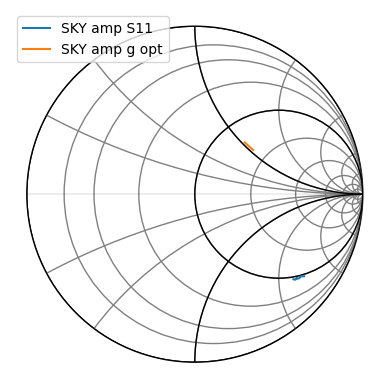

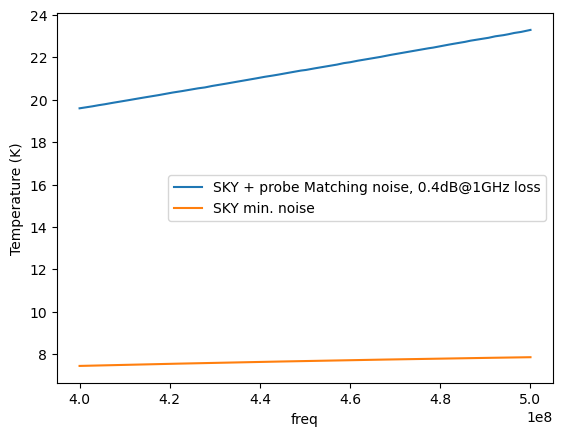

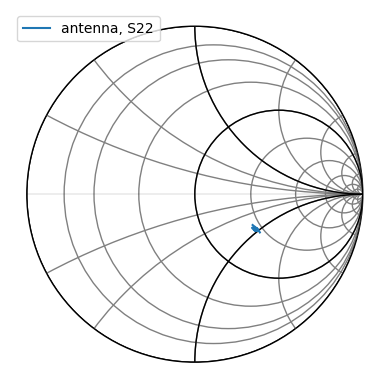

In [16]:
freq_low = 4e8
freq_high = 5e8
freq = np.linspace(freq_low, freq_high, 1001)

SKY = rf.Network("SKY67183_5V_53mA_25C_Deembedded_SP_w_Noise.s2p")
SKY.resample(freq)

Probe = rf.Network("PROBE_150OHM.s2p")
Probe.resample(freq)

db_loss_1GHz = 0.4
db_loss = freq/1e9*db_loss_1GHz

Probe_2_port = Antenna_setup_corrected(Probe.s[:,0,0], Probe.f, 50, 10**(-db_loss/10))

#Probe_2_port.plot_s_smith(m=1, n=1, label = "probe S22")

noise_plot = rf.Network(name="g_opt", s=SKY.g_opt)
SKY.plot_s_smith(m=0, n=0, label = "SKY amp S11")
noise_plot.plot_s_smith(m=0, n=0, label = "SKY amp g opt")
plt.show()

match = Probe_2_port**SKY

plt.plot(SKY.f, 290*(match.nf(50)-1), label = "SKY + probe Matching noise, 0.4dB@1GHz loss")
plt.plot(SKY.f, 290*(SKY.nfmin-1), label = "SKY min. noise")
plt.legend()
plt.xlabel("freq")
plt.ylabel("Temperature (K)")
plt.show()

match.plot_s_smith(m=1, n=1)


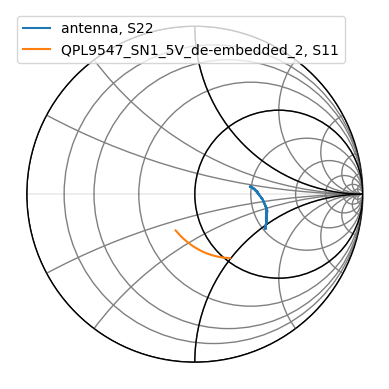

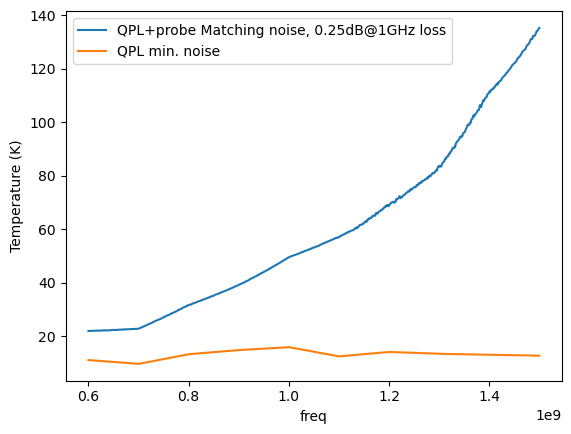

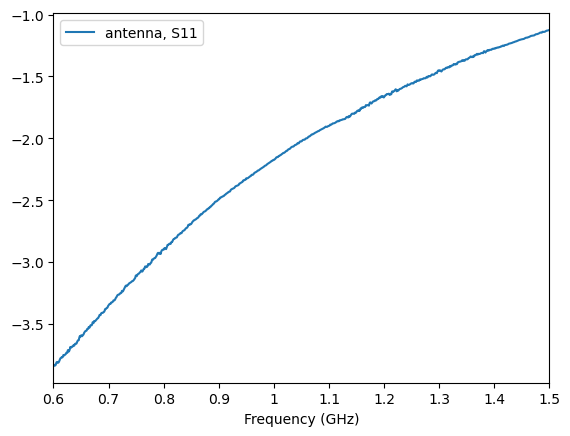

In [188]:
freq = np.linspace(6e8, 1.5e9, 1001)

QPL = rf.Network("QPL9547_SN1_5V_de-embedded_2.s2p")
QPL.resample(freq)

Probe = rf.Network("PROBE_150OHM.s2p")
Probe.resample(freq)

db_loss_1GHz = 0.1
db_loss = freq/1e9*db_loss_1GHz

Probe_2_port = Antenna_setup_corrected(Probe.s[:,0,0], QPL.f, 50, 10**(-db_loss/10))

Probe_2_port.plot_s_smith(m=1, n=1)
QPL.plot_s_smith(m=0, n=0)

plt.show()

media = rf.media.DefinedGammaZ0(frequency = rf.Frequency.from_f(freq), z0_port = 50, z0=50)

ANT_2_port = Antenna_setup_corrected((ANT.s[:,0,0]), ANT.f, 50, 0.97)


match = Probe_2_port**media.inductor(-20e-9)**QPL

plt.plot(QPL.f, 290*(match.nf(50)-1), label = "QPL+probe Matching noise, 0.25dB@1GHz loss")
plt.plot(QPL.f, 290*(QPL.nfmin-1), label = "QPL min. noise")
plt.legend()
plt.xlabel("freq")
plt.ylabel("Temperature (K)")
plt.show()

match.plot_s_db(m=0,  n=0)

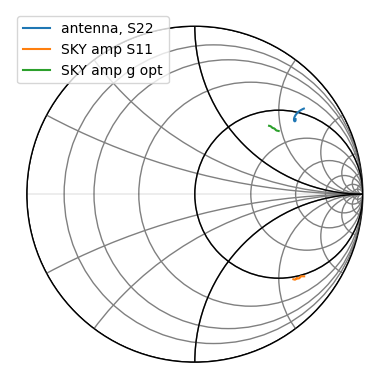

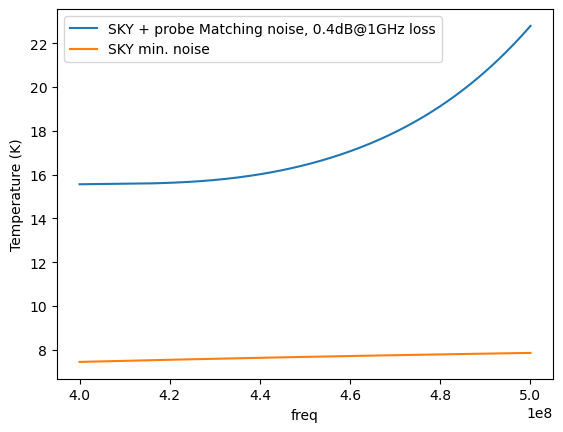

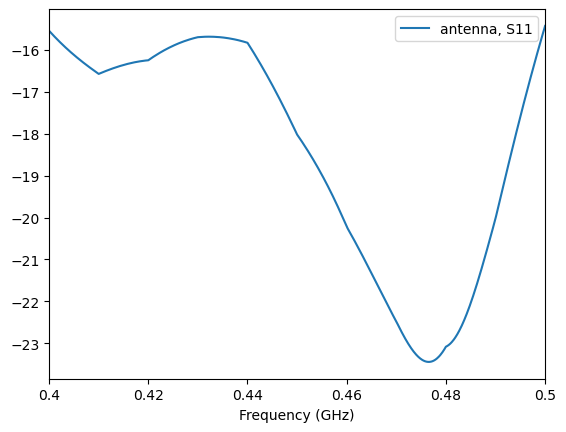

In [55]:
ring_dipole_s11 = rf.Network("ring_dipole_S11_1.s1p")
ring_dipole_s11.resample(freq)

db_loss_1GHz = 0.15
db_loss = freq/1e9*db_loss_1GHz

ring_dipole = Antenna_setup_corrected(ring_dipole_s11.s[:,0,0], Probe.f, 50, 10**(-db_loss/10))

base_Media = rf.media.DefinedGammaZ0(frequency=rf.Frequency.from_f(freq))
inductor = base_Media.inductor(45e-9)

antenna_inductor = ring_dipole**inductor

antenna_inductor.plot_s_smith(m=1, n=1)
SKY.plot_s_smith(m=0, n=0, label = "SKY amp S11")
noise_plot = rf.Network(name="opt_pt", s=(SKY.g_opt+np.conj(SKY.s[:,0,0]))/2)
noise_plot.plot_s_smith(m=0, n=0, label = "SKY amp g opt")

plt.show()

match = antenna_inductor**SKY

plt.plot(SKY.f, 290*(match.nf(50)-1), label = "SKY + probe Matching noise, 0.4dB@1GHz loss")
plt.plot(SKY.f, 290*(SKY.nfmin-1), label = "SKY min. noise")
plt.legend()
plt.xlabel("freq")
plt.ylabel("Temperature (K)")
plt.show()

match.plot_s_db(m=0, n=0)


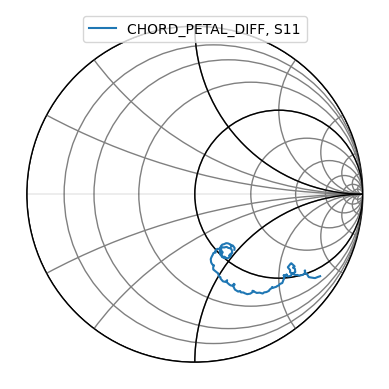

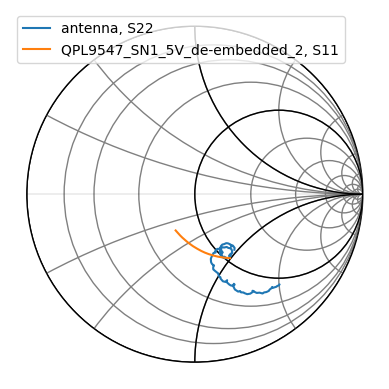

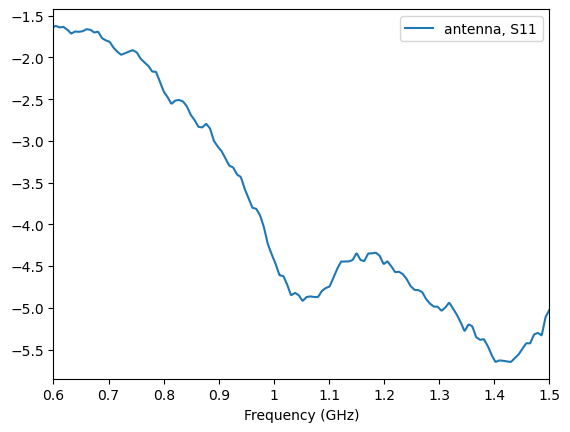

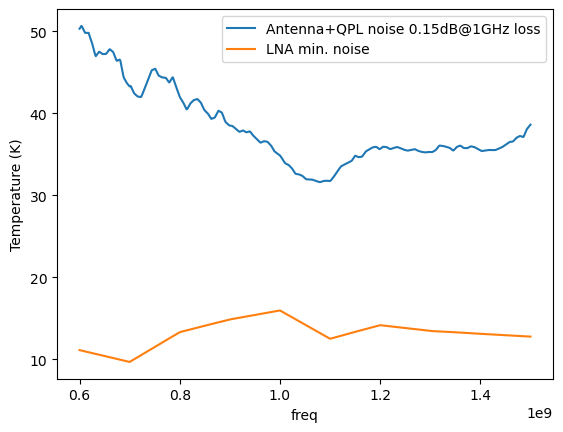

In [181]:
freq = np.linspace(6e8, 1.5e9, 1001)
freq2 = np.linspace(3e8, 1.5e9, 1001)

QPL = rf.Network("QPL9547_SN1_5V_de-embedded_2.s2p")
QPL.resample(freq)

ANT = rf.Network("CHORD_PETAL_DIFF.s2p")
ANT.resample(freq2)
ANT.plot_s_smith(m=0, n=0)
ANT.resample(freq)


db_loss_1GHz = 0.15
db_loss = freq/1e9*db_loss_1GHz

ANT_2_port = Antenna_setup_corrected(ANT.s[:,0,0], ANT.f, 50, 10**(-db_loss/10))

plt.show()

ANT_2_port.plot_s_smith(m=1, n=1)
QPL.plot_s_smith(m=0, n=0)

plt.show()

match = ANT_2_port**QPL
match.plot_s_db(m=0, n=0)
plt.show()

plt.plot(QPL.f, 290*(match.nf(50)-1), label = "Antenna+QPL noise 0.15dB@1GHz loss")
plt.plot(QPL.f, 290*(QPL.nfmin-1), label = "LNA min. noise")
plt.legend()
plt.xlabel("freq")
plt.ylabel("Temperature (K)")
plt.show()


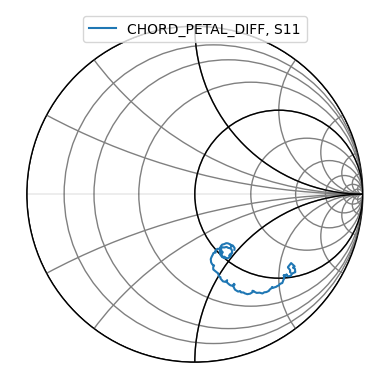

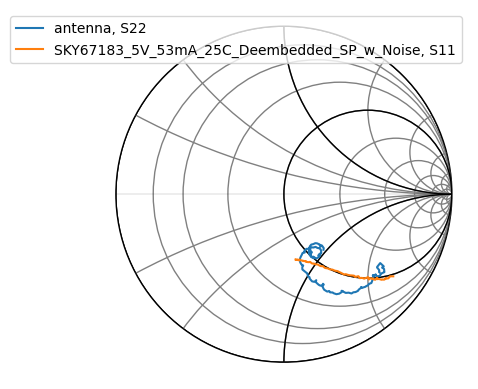

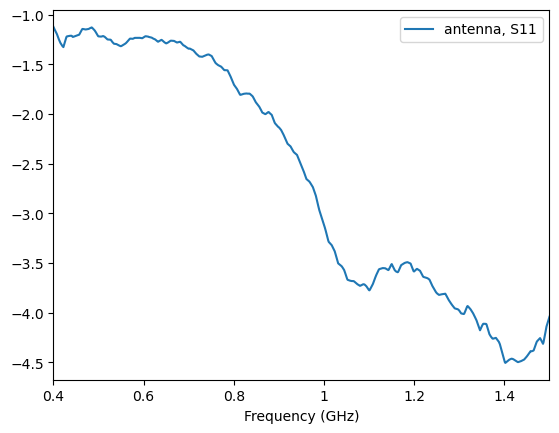

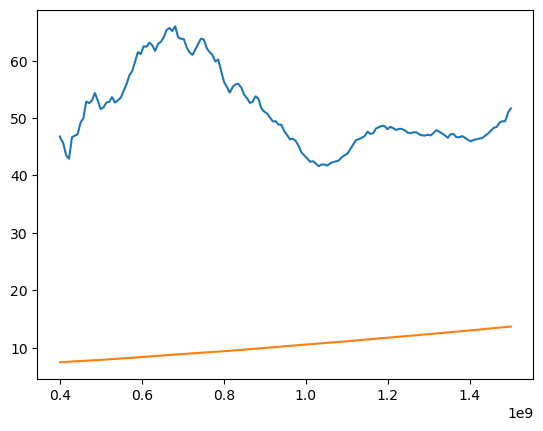

In [180]:
freq = np.linspace(4e8, 1.5e9, 1001)

SKY = rf.Network("SKY67183_5V_53mA_25C_Deembedded_SP_w_Noise.s2p")
SKY.resample(freq)

ANT = rf.Network("CHORD_PETAL_DIFF.s2p")
ANT.resample(freq)
ANT.plot_s_smith(m=0, n=0)
plt.show()

ANT_2_port = Antenna_setup_corrected(ANT.s[:,0,0], ANT.f, 50, 0.95)
ANT_2_port.plot_s_smith(m=1, n=1)
SKY.plot_s_smith(m=0, n=0)

plt.show()

match = ANT_2_port**SKY
match.plot_s_db(m=0, n=0)
plt.show()

plt.plot(SKY.f, 290*(match.nf(50)-1), label = "Matchinng noise with SNR")
plt.plot(SKY.f, 290*(SKY.nfmin-1), label = "LNA min. noise")
plt.show()

Text(35.347222222222214, 0.5, 'S11 (dB)')

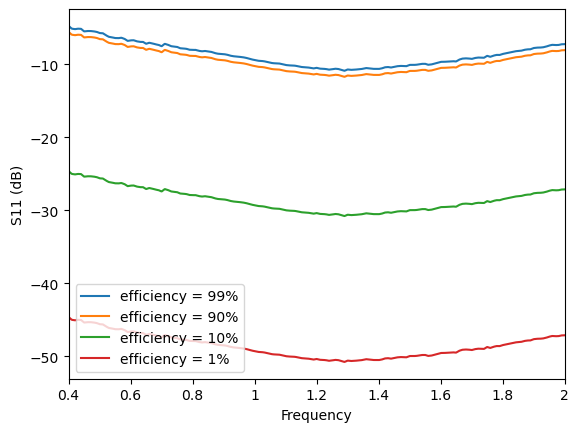

In [37]:
SKY = rf.Network("SKY67183_5V_53mA_25C_Deembedded_SP_w_Noise.s2p")
SKY.crop(1e8, 2e9)
SKY.resample(1001)

Ant_test_SKY_99 = Antenna_setup_corrected(SKY.g_opt, SKY.f, 50, 0.99)
Ant_test_SKY_90 = Antenna_setup_corrected(SKY.g_opt, SKY.f, 50, 0.90)
Ant_test_SKY_10 = Antenna_setup_corrected(SKY.g_opt, SKY.f, 50, 0.10)
Ant_test_SKY_1 = Antenna_setup_corrected(SKY.g_opt, SKY.f, 50, 0.01)

match_SKY_99 = Ant_test_SKY_99**SKY
match_SKY_90 = Ant_test_SKY_90**SKY
match_SKY_10 = Ant_test_SKY_10**SKY
match_SKY_1 = Ant_test_SKY_1**SKY

#plt.plot(SKY.f, 290*(match_SKY_conj.nf(50)-1), label = "Conjugate Match")
#plt.plot(SKY.f, 290*(match_SKY_opt.nf(50)-1), label = "Optimal Match")
#plt.plot(SKY.f, 290*(SKY.nfmin-1), label = "LNA min. noise")

match_SKY_99.plot_s_db(m=0, n=0, label="efficiency = 99%")
match_SKY_90.plot_s_db(m=0, n=0, label="efficiency = 90%")
match_SKY_10.plot_s_db(m=0, n=0, label="efficiency = 10%")
match_SKY_1.plot_s_db(m=0, n=0, label="efficiency = 1%")


plt.legend()
plt.xlabel("Frequency")
plt.ylabel("S11 (dB)")

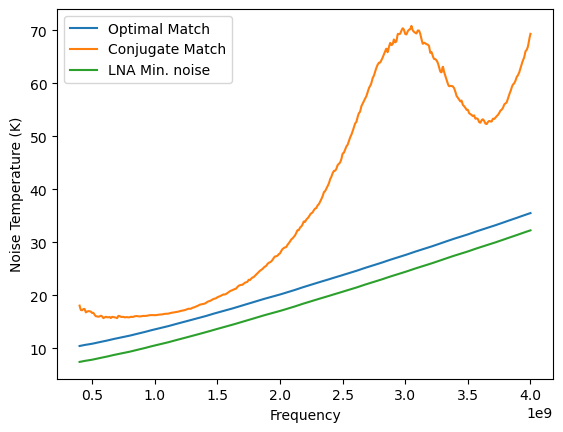

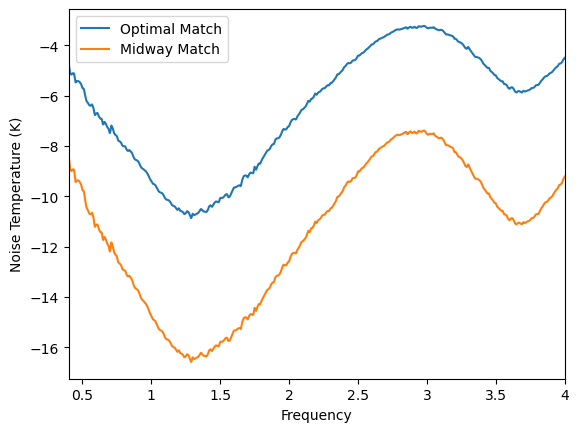

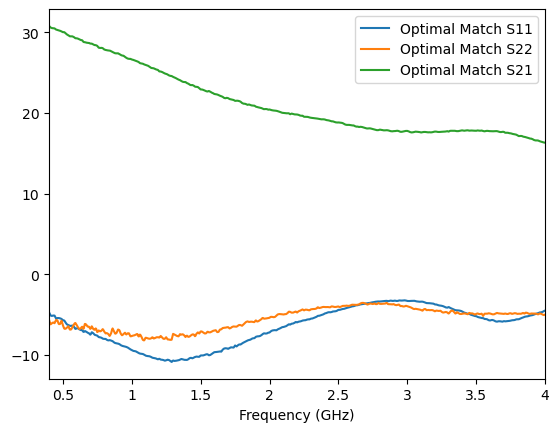

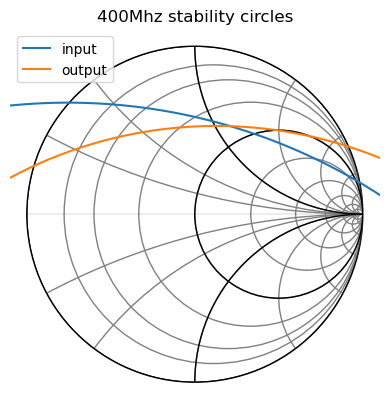

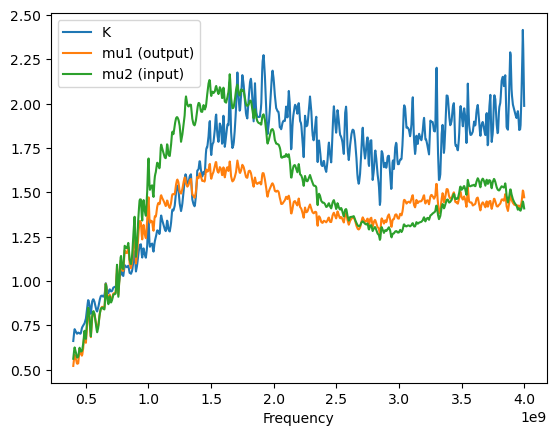

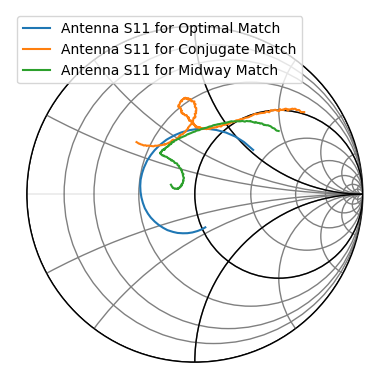

In [36]:
#test SKY amp
SKY = rf.Network("SKY67183_5V_53mA_25C_Deembedded_SP_w_Noise.s2p")
SKY.crop(1e8, 4e9)
SKY.resample(1001)

Ant_test_SKY_opt = Antenna_setup_corrected(SKY.g_opt, SKY.f, 50, 0.99)
Ant_test_SKY_conj = Antenna_setup_corrected(np.conj(SKY.s[:,0,0]), SKY.f, 50, 0.99)
Ant_test_SKY_mid = Antenna_setup_corrected(0.5*np.conj(SKY.s[:,0,0])+0.5*SKY.g_opt, SKY.f, 50, 0.99)

match_SKY_opt = Ant_test_SKY_opt**SKY
match_SKY_conj = Ant_test_SKY_conj**SKY
match_SKY_mid = Ant_test_SKY_mid**SKY

plt.plot(SKY.f, 290*(match_SKY_opt.nf(50)-1), label = "Optimal Match")
plt.plot(SKY.f, 290*(match_SKY_conj.nf(50)-1), label = "Conjugate Match")
plt.plot(SKY.f, 290*(SKY.nfmin-1), label = "LNA Min. noise")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Noise Temperature (K)")
plt.show()

match_SKY_opt.plot_s_db(m=0, n=0, label = "Optimal Match")
match_SKY_mid.plot_s_db(m=0, n=0, label = "Midway Match")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Noise Temperature (K)")
plt.show()

match_SKY_opt.plot_s_db(m=0, n=0, label = "Optimal Match S11")
match_SKY_opt.plot_s_db(m=1, n=1, label = "Optimal Match S22")
match_SKY_opt.plot_s_db(m=1, n=0, label = "Optimal Match S21")
plt.show()

Stability_circle(match_SKY_opt, 4e8)[0].plot_s_smith(label = "input")
Stability_circle(match_SKY_opt, 4e8)[1].plot_s_smith(label = "output")
plt.title("400Mhz stability circles")
plt.legend()
plt.show()

match_opt_stability_factor = Stability_factor(match_SKY_opt)
plt.plot(SKY.f, match_opt_stability_factor[0], label = "K")
plt.plot(SKY.f, match_opt_stability_factor[1], label = "mu1 (output)")
plt.plot(SKY.f, match_opt_stability_factor[2], label = "mu2 (input)")
plt.legend()
plt.xlabel("Frequency")
plt.show()

Ant_test_SKY_opt.plot_s_smith(m=1, n=1, label = "Antenna S11 for Optimal Match")
Ant_test_SKY_conj.plot_s_smith(m=1, n=1, label = "Antenna S11 for Conjugate Match")
Ant_test_SKY_mid.plot_s_smith(m=1, n=1, label = "Antenna S11 for Midway Match")



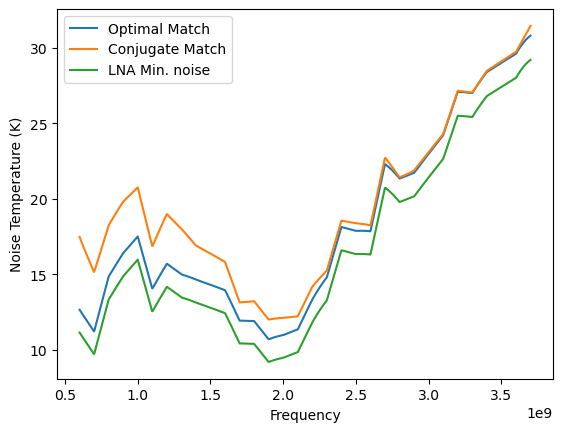

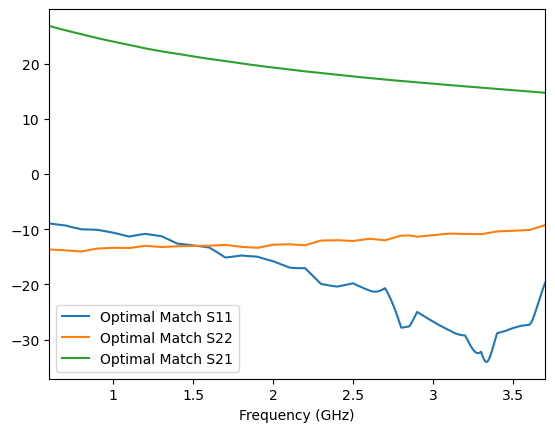

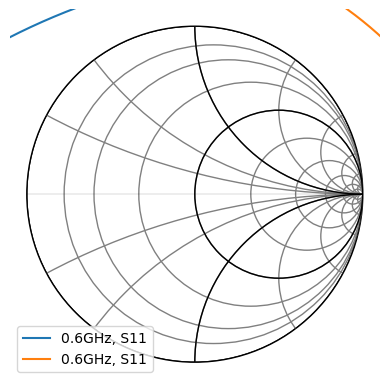

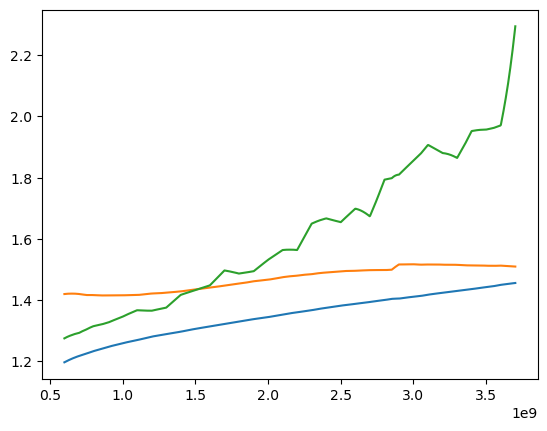

In [32]:
#test QPL amp
QPL = rf.Network("QPL9547_SN1_5V_de-embedded_2.s2p")
QPL.crop(6e8, 3.7e9)
QPL.resample(1001)

Ant_test_QPL_opt = Antenna_setup_corrected(QPL.g_opt, QPL.f, 50, 0.995)
Ant_test_QPL_conj = Antenna_setup_corrected(np.conj(QPL.s[:,0,0]), QPL.f, 50, 0.995)

match_QPL_opt = Ant_test_QPL_opt**QPL
match_QPL_conj = Ant_test_QPL_conj**QPL

plt.plot(QPL.f, 290*(match_QPL_opt.nf(50)-1), label = "Optimal Match")
plt.plot(QPL.f, 290*(match_QPL_conj.nf(50)-1), label = "Conjugate Match")
plt.plot(QPL.f, 290*(QPL.nfmin-1), label = "LNA Min. noise")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Noise Temperature (K)")
plt.show()


match_QPL_opt.plot_s_db(m=0, n=0, label = "Optimal Match S11")
match_QPL_opt.plot_s_db(m=1, n=1, label = "Optimal Match S22")
match_QPL_opt.plot_s_db(m=1, n=0, label = "Optimal Match S21")
plt.show()

Stability_circle(match_QPL_opt, 6e8)[0].plot_s_smith()
Stability_circle(match_QPL_opt, 6e8)[1].plot_s_smith()

plt.show()

match_stability_factor = Stability_factor(match_QPL_opt)
plt.plot(QPL.f, match_stability_factor[0])
plt.plot(QPL.f, match_stability_factor[1])
plt.plot(QPL.f, match_stability_factor[2])
plt.show()


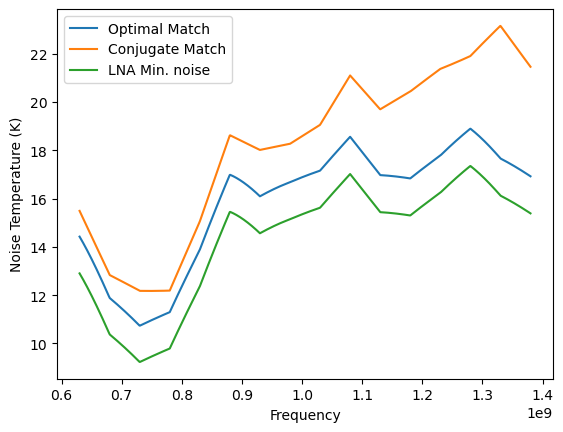

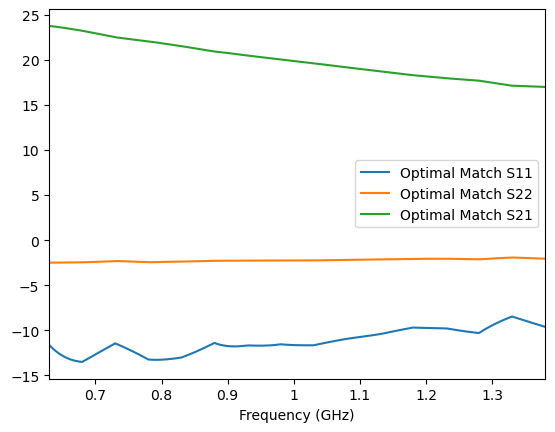

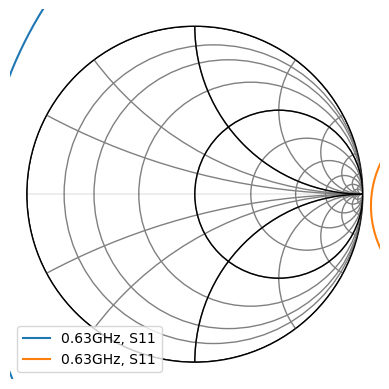

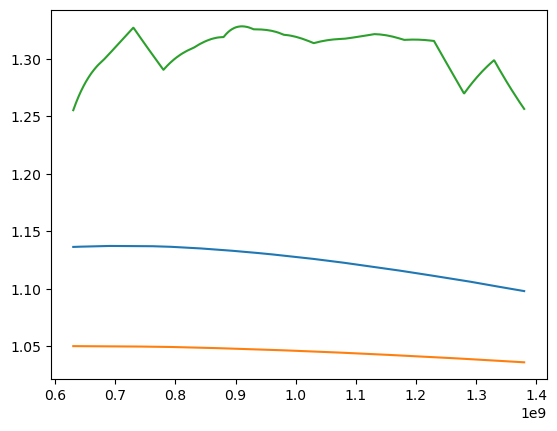

In [33]:
#test TQL amp
TQL = rf.Network("TQL9066-single-de-embedded-s-prameters-with-noise-parameters.s2p")
TQL.crop(6.3e8, 1.38e9)
TQL.resample(1001)

Ant_test_TQL_opt = Antenna_setup_corrected(TQL.g_opt, TQL.f, 50, 0.995)
Ant_test_TQL_conj = Antenna_setup_corrected(np.conj(TQL.s[:,0,0]), TQL.f, 50, 0.995)

match_TQL_opt = Ant_test_TQL_opt**TQL
match_TQL_conj = Ant_test_TQL_conj**TQL

plt.plot(TQL.f, 290*(match_TQL_opt.nf(50)-1), label = "Optimal Match")
plt.plot(TQL.f, 290*(match_TQL_conj.nf(50)-1), label = "Conjugate Match")
plt.plot(TQL.f, 290*(TQL.nfmin-1), label = "LNA Min. noise")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Noise Temperature (K)")
plt.show()

match_TQL_opt.plot_s_db(m=0, n=0, label = "Optimal Match S11")
match_TQL_opt.plot_s_db(m=1, n=1, label = "Optimal Match S22")
match_TQL_opt.plot_s_db(m=1, n=0, label = "Optimal Match S21")
plt.show()

Stability_circle(match_TQL_opt, 6.3e8)[0].plot_s_smith()
Stability_circle(match_TQL_opt, 6.3e8)[1].plot_s_smith()

plt.show()

match_stability_factor = Stability_factor(match_TQL_opt)
plt.plot(TQL.f, match_stability_factor[0])
plt.plot(TQL.f, match_stability_factor[1])
plt.plot(TQL.f, match_stability_factor[2])
plt.show()